In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for col in columns:
    print(col["name"], col["type"])
    
entries = session.query(Measurement, Measurement.date).order_by(Measurement.date.desc())
mostrecent = entries[0][1]
print(mostrecent)

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
annumpost = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, func.max(Measurement.prcp)).filter(Measurement.date >= annumpost).group_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')
df = df.set_index('Date')
df



,Precipitation
Date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


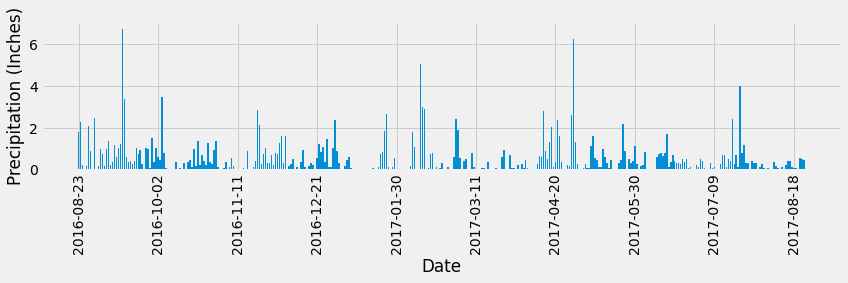

,Precipitation
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
from matplotlib.ticker import MaxNLocator

fig,axes = plt.subplots(1,1)
fig.set_size_inches(12, 4)
axes.bar(df.index, df['Precipitation'])
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.xticks(rotation = 90)
axes.xaxis.set_major_locator(MaxNLocator(12)) 
plt.tight_layout()
plt.show()

# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
stations = []
finder = session.query(Station)
for station in finder:
    stations.append(station)

print(len(stations))

9


In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
actives = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station)
activeorder = actives.order_by(func.count(Measurement.id).desc()).all()
activeorder

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
leader = activeorder[0][0]
summaryinfo = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == leader).with_entities(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all()
print(leader, summaryinfo)


USC00519281 [(54.0, 85.0, 71.66378066378067)]


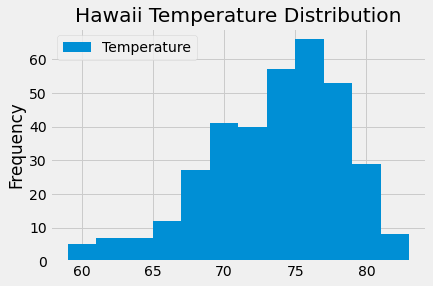

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
lastleader = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == leader).filter(Measurement.date >= annumpost).all()
station_df = pd.DataFrame(lastleader, columns=['Date', 'Temperature']).set_index('Date')
station_df.plot.hist(title='Hawaii Temperature Distribution', bins=12)
plt.show()

# Close session

In [32]:
# Close Session
session.close()